In [50]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [51]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
ticker = "TCS.NS"
start_date = "2020-01-01"
end_date = "2024-12-31"

In [53]:
import yfinance as yf

In [54]:
print(df.columns)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA20', 'STD20', 'Z_score',
       'Signal', 'Position', 'Market_Return', 'Strategy_Return',
       'Cumulative_Market', 'Cumulative_Strategy', 'RSI', 'SMA200', 'Regime'],
      dtype='object')


In [55]:
import yfinance as yf

ticker = "TCS.NS"
start_date = "2020-01-01"
end_date = "2024-12-31"

df = yf.download(ticker, start=start_date, end=end_date)

# Check actual columns
print("Available columns:", df.columns)

# Safely select available ones
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.head())


[*********************100%***********************]  1 of 1 completed

Available columns: MultiIndex([( 'Close', 'TCS.NS'),
            (  'High', 'TCS.NS'),
            (   'Low', 'TCS.NS'),
            (  'Open', 'TCS.NS'),
            ('Volume', 'TCS.NS')],
           names=['Price', 'Ticker'])
Price              Open         High          Low        Close   Volume
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
Date                                                                   
2020-01-01  1979.527369  1994.045031  1966.744443  1979.162231  1354908
2020-01-02  1990.438815  1990.438815  1962.362027  1970.077393  2380752
2020-01-03  1975.875203  2029.746107  1975.875203  2009.338989  4655761
2020-01-06  2013.310868  2032.439559  1997.697347  2009.156372  3023209
2020-01-07  2009.202165  2022.121962  1993.954004  2014.087158  2429317


In [56]:
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()

In [8]:
df['Z_score'] = (df['Close'] - df['SMA20']) / df['STD20']

ValueError: Cannot set a DataFrame with multiple columns to the single column Z_score

In [9]:
close = df['Close']  # This ensures you're working with a Series

df['SMA20'] = close.rolling(window=20).mean()
df['STD20'] = close.rolling(window=20).std()

# Step 3: Compute Z-Score safely
df['Z_score'] = (close - df['SMA20']) / df['STD20']

ValueError: Cannot set a DataFrame with multiple columns to the single column Z_score

In [57]:
print(type(df['SMA20']))
print(type(df['STD20']))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [58]:
print(df.columns)


MultiIndex([(  'Open', 'TCS.NS'),
            (  'High', 'TCS.NS'),
            (   'Low', 'TCS.NS'),
            ( 'Close', 'TCS.NS'),
            ('Volume', 'TCS.NS'),
            ( 'SMA20',       ''),
            ( 'STD20',       '')],
           names=['Price', 'Ticker'])


In [59]:
# Flatten MultiIndex columns to simple strings
df.columns = ['_'.join(filter(None, map(str, col))) for col in df.columns]


In [61]:
df.rename(columns={
    'Open_TCS.NS': 'Open',
    'High_TCS.NS': 'High',
    'Low_TCS.NS': 'Low',
    'Close_TCS.NS': 'Close',
    'Volume_TCS.NS': 'Volume'
}, inplace=True)


In [62]:
df['Z_score'] = (df['Close'] - df['SMA20']) / df['STD20']

In [63]:
df['Signal'] = 0
df.loc[df['Z_score'] < -0.5, 'Signal'] = 1   # Buy
df.loc[df['Z_score'] > 0.5, 'Signal'] = -1   # Sell

In [64]:
df['Position'] = df['Signal'].shift()

In [65]:
df['Market_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Market_Return'] * df['Position']

In [66]:
df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()

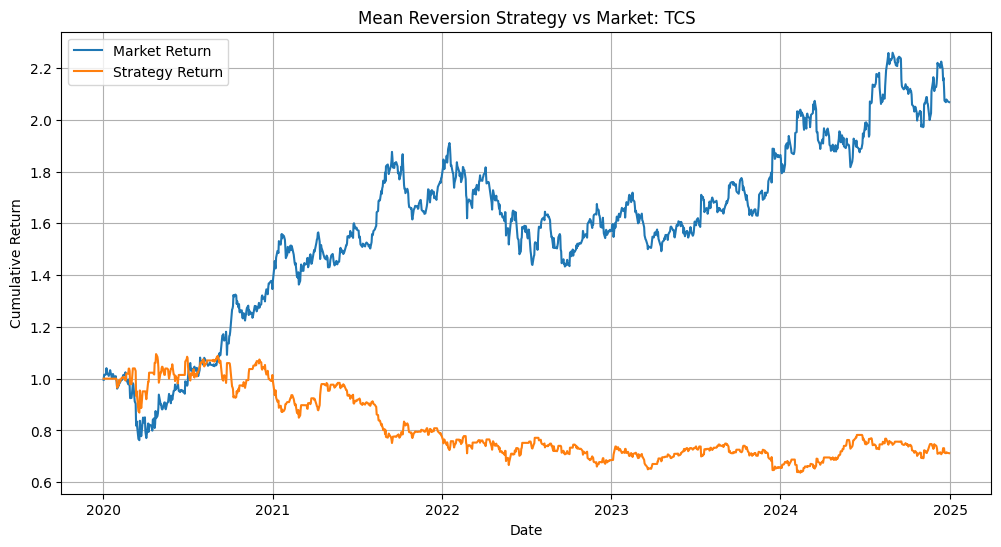

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Market'], label='Market Return')
plt.plot(df['Cumulative_Strategy'], label='Strategy Return')
plt.title('Mean Reversion Strategy vs Market: TCS')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
import matplotlib.pyplot as plt


In [69]:
delta = df['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

In [70]:
df['SMA200'] = df['Close'].rolling(window=200).mean()
df['Regime'] = np.where(df['SMA200'].diff() > 0, 'Bull', 'Bear')

In [71]:
def calculate_metrics(df):
    strategy_return = df['Strategy_Return'].dropna()
    cumulative_return = df['Cumulative_Strategy'].iloc[-1] - 1
    annualized_return = strategy_return.mean() * 252
    sharpe_ratio = (strategy_return.mean() / strategy_return.std()) * np.sqrt(252)
    sortino_ratio = (strategy_return.mean() / strategy_return[strategy_return < 0].std()) * np.sqrt(252)
    max_drawdown = ((df['Cumulative_Strategy'] / df['Cumulative_Strategy'].cummax()) - 1).min()

    win_rate = (strategy_return > 0).sum() / strategy_return.count()
    avg_profit = strategy_return[strategy_return > 0].mean()
    avg_loss = strategy_return[strategy_return < 0].mean()
    max_profit = strategy_return.max()
    max_loss = strategy_return.min()
    profit_factor = -avg_profit / avg_loss

    return pd.DataFrame({
        'Cumulative Return': [cumulative_return],
        'Annualized Return': [annualized_return],
        'Sharpe Ratio': [sharpe_ratio],
        'Sortino Ratio': [sortino_ratio],
        'Max Drawdown': [max_drawdown],
        'Win Rate': [win_rate],
        'Profit Factor': [profit_factor],
        'Avg Profit': [avg_profit],
        'Avg Loss': [avg_loss],
        'Max Profit': [max_profit],
        'Max Loss': [max_loss]
    })

metrics_df = calculate_metrics(df)
print(metrics_df.T)

                          0
Cumulative Return -0.288050
Annualized Return -0.046761
Sharpe Ratio      -0.220675
Sortino Ratio     -0.259408
Max Drawdown      -0.418654
Win Rate           0.370550
Profit Factor      1.034367
Avg Profit         0.010658
Avg Loss          -0.010303
Max Profit         0.098451
Max Loss          -0.094104


In [72]:
import yfinance as yf

# Set date range
start_date = "2020-01-01"
end_date = "2024-12-31"

# Download Nifty 50 data
nifty = yf.download("^NSEI", start=start_date, end=end_date)

# Preview data
print(nifty.head())


[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open  Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   ^NSEI
Date                                                                      
2020-01-01  12182.500000  12222.200195  12165.299805  12202.150391  304100
2020-01-02  12282.200195  12289.900391  12195.250000  12198.549805  407700
2020-01-03  12226.650391  12265.599609  12191.349609  12261.099609  428800
2020-01-06  11993.049805  12179.099609  11974.200195  12170.599609  396500
2020-01-07  12052.950195  12152.150391  12005.349609  12079.099609  447800


In [76]:
# Download Nifty 50 index data for benchmark comparison
nifty = yf.download("^NSEI", start=start_date, end=end_date)
nifty['Market Return'] = nifty['Close'].pct_change()
nifty['Cumulative Return'] = (1 + nifty['Market Return']).cumprod()

# Align index with TCS data
df['Nifty Return'] = nifty['Market Return']
df['Nifty Cumulative'] = (1 + df['Nifty Return'].fillna(0)).cumprod()

# Calculate excess return of strategy vs. Nifty
df['Excess Return'] = df['Strategy Return'] - df['Nifty Return']
excess_cumulative_return = df['Cumulative Strategy'].iloc[-1] - df['Nifty Cumulative'].iloc[-1]
tracking_error = df['Excess Return'].std() * np.sqrt(252)
information_ratio = df['Excess Return'].mean() / df['Excess Return'].std() * np.sqrt(252)


[*********************100%***********************]  1 of 1 completed


In [87]:
df['Market Return'] = df['Close'].pct_change(fill_method=None)
df['Market Return'] = df['Market Return'].fillna(0)  # fill NaN for first row


In [74]:

df['Strategy Return'] = df['Position'].shift(1) * df['Market Return']
df.dropna(inplace=True)  # This removes rows with NaN, so make sure you do it **after** calculating returns


In [75]:
# Assuming you already have 'Strategy Return' and 'Market Return' calculated...

df['Cumulative Market'] = (1 + df['Market Return']).cumprod()
df['Cumulative Strategy'] = (1 + df['Strategy Return']).cumprod()

# Similarly for Nifty cumulative returns, if you haven't:
df['Nifty Cumulative'] = (1 + df['Nifty Return'].fillna(0)).cumprod()


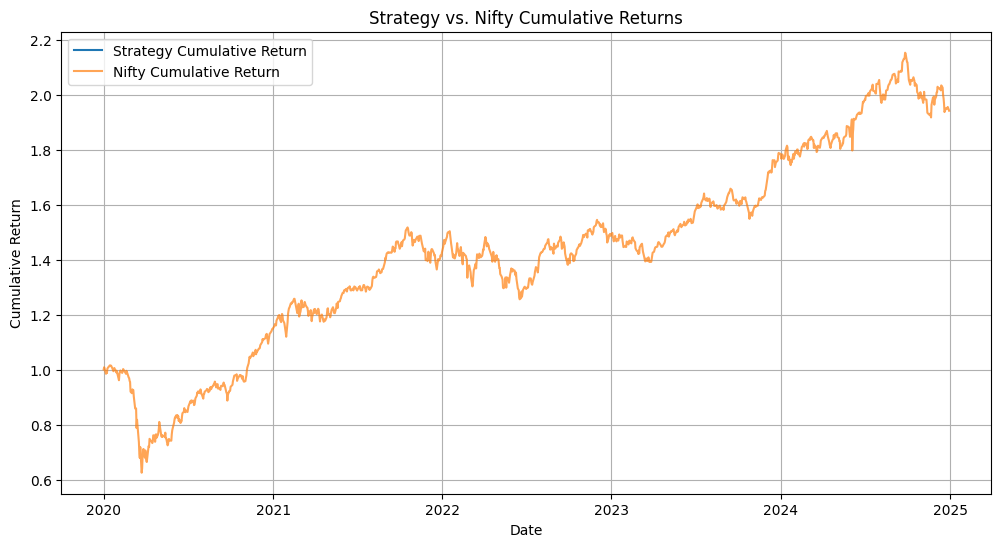

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative Strategy'], label='Strategy Cumulative Return')
plt.plot(df.index, df['Nifty Cumulative'], label='Nifty Cumulative Return', alpha=0.7)
plt.title('Strategy vs. Nifty Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()
